<a href="https://colab.research.google.com/github/Prashanth1194/Google-Analytics-Analysis/blob/master/Codes/Data_Wrangling_and_Exploratory_Analysis_PS_BP_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading the libraries

In [1]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 4.1MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [2]:
!pip install -U imbalanced-learn

    100% |████████████████████████████████| 174kB 7.0MB/s 
    100% |████████████████████████████████| 5.3MB 6.0MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2


In [3]:
!pip install sklearn

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [0]:
#https://drive.google.com/open?id=1wNZD95CltyE2vcpUVYiBjNJAeciaf9Jj
#https://drive.google.com/open?id=1OkSd5HolKqcQ1wYQpxJg46WrVc7YwxmA
file_id = '14-TJPt3XPUdLgdb2xwa1ZzovLRQXIsXe'
#https://drive.google.com/open?id=14-TJPt3XPUdLgdb2xwa1ZzovLRQXIsXe
downloaded = drive.CreateFile({'id': file_id})
# allows you to temporarily load your file in the notebook VM

# assume the file is called file.csv and it's located at the root of your drive
downloaded.GetContentFile('train-flattened_v2.csv')

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [6]:
train_df = pd.read_csv("train-flattened_v2.csv")
print(train_df.shape)
train_df['trafficSource.adContent'].value_counts()

(903653, 55)


Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
Google Merchandise                               87
First Full Auto Template Test Ad                 87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:Goo

### Sneak Peek at the data

In [7]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


### Getting the categorical and numerical columns

In [0]:
cols = train_df.columns
num_cols = train_df._get_numeric_data().columns
factor_cols = list(set(cols) - set(num_cols))

### Getting the count of missing values in the categorical values and plotting the same

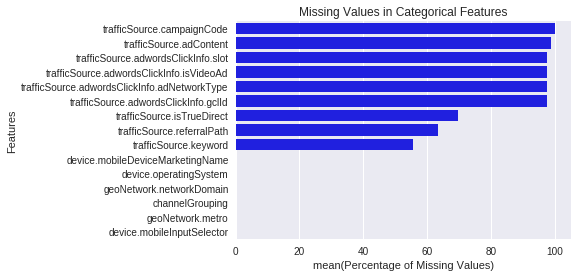

In [9]:
total_test = train_df[factor_cols].isnull().sum().sort_values(ascending=False)
percent = (train_df[factor_cols].isnull().sum()/train_df[factor_cols].isnull().count()).sort_values(ascending=False)*100
data_to_be_removed = pd.concat([total_test, percent], axis=1,join='outer', keys=['Missing Value Count', 'Percentage of Missing Values'])
data_to_be_removed.index.name ='Features'
#data_to_be_removed.head(20)
sns.barplot(y = data_to_be_removed.index[:15],x = data_to_be_removed['Percentage of Missing Values'][:15],color='blue').set_title("Missing Values in Categorical Features")
missing_cols = list(data_to_be_removed[data_to_be_removed['Percentage of Missing Values']>50.0].iloc[:,1].index)

### Getting the count of missing values in the continuous variables and plotting it

Text(0.5,1,'Missing Values in Continuous Features')

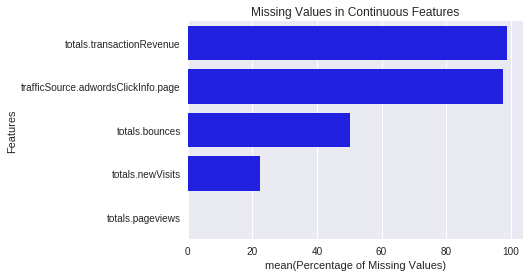

In [10]:
total_test1 = train_df[num_cols].isnull().sum().sort_values(ascending=False)
percent1 = (train_df[num_cols].isnull().sum()/train_df[num_cols].isnull().count()).sort_values(ascending=False)*100
data_to_be_removed1 = pd.concat([total_test1, percent1], axis=1,join='outer', keys=['Missing Value Count', 'Percentage of Missing Values'])
data_to_be_removed1.index.name ='Features'
#data_to_be_removed.head(20)
sns.barplot(y = data_to_be_removed1.index[:5],x = data_to_be_removed1['Percentage of Missing Values'][:5],color='blue').set_title("Missing Values in Continuous Features")

     Note : The feature 'totals.transactionRevenue' is the revenue generated in every session/log in of each user and if it's   missing, it means that no revenue was generated. So, rather than dropping the missing values, we should recode it to 0 in this case


### Removing Categorical features with just 1 level

In [11]:
single_level_cols = [cols for cols in train_df[factor_cols].columns if train_df[cols].nunique(dropna=False)==1 ]
train_df.drop(single_level_cols,axis=1,inplace=True)
print(train_df.shape)

(903653, 37)


### Before proceeding further with the exploratory analysis, we will generate our target variable of interest : Flag indicating if a customer is a revenue generating customer or not

In [0]:
group_cols = ['fullVisitorId']
counted = 'totals.transactionRevenue'
agg_name = 'totals.transactionRevenue_sum'
gp = train_df[group_cols+[counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted:agg_name})
#print(gp)
#train = train.merge(gp, on=group_cols, how='left')
gp['Revenue_Generating_Flag'] = np.where(gp['totals.transactionRevenue_sum']>0,1,0)
cols = ['fullVisitorId','Revenue_Generating_Flag']

train_df1 = pd.merge(train_df,gp[cols],on='fullVisitorId',how='inner')

### Data Wrangling / Cleaning

In [0]:
class Wrangler:
    
    def browser_wrangling(self,x):
        top_10_browsers = ['chrome','safari','firefox','internet explorer','edge','android webview','safari (in-app)','opera mini','opera','uc browser']
        #browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
        #mobile_browsers = ['android','samsung','mini','iphone','in-app','playstation','mozilla','chrome','blackberry','nokia','browser','amazon','lunascape','netscape','konqueror','puffin']
    
        if x in top_10_browsers:
            return x.lower()
    
        
        elif '(not set)' in x:
            return x
    
        else:
            return 'others'

        
    def source_wrangling(self,x):
        if  ('google' in x):
            return 'google'
        elif  ('youtube' in x):
            return 'youtube'
        elif 'yahoo' in x:
            return 'yahoo'
        elif 'facebook' in x:
            return 'facebook'
        elif 'reddit' in x:
            return 'reddit'
        elif 'bing' in x:
            return 'bing'
        elif 'quora' in x:
            return 'quora'
        elif 'outlook' in x:
            return 'outlook'
        elif 'linkedin' in x:
            return 'linkedin'
        elif 'twitter' in x:
            return 'twitter'
        elif '(not set)' in x or 'nan' in x:
            return x
        else:
            return 'others'
        
    def device_os_wrangling(self,x):
        top_10_device_os = ['windows','macintosh','andorid','ios', 'linux','chrome os','windows phone']
        #browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
        #mobile_browsers = ['android','samsung','mini','iphone','in-app','playstation','mozilla','chrome','blackberry','nokia','browser','amazon','lunascape','netscape','konqueror','puffin']

        if x in top_10_device_os:
            return x.lower()

        #elif x in mobile_browsers:
         #   return 'mobile browser'

        elif '(not set)' in x:
            return x

        else:
            return 'others'
        
    def nw_domain_wrangling(self,x):
        tt = x['geoNetwork.networkDomain'].value_counts()
        tt = pd.DataFrame(tt)
        #tt['geoNetwork.networkDomain'] = tt.index
        tt['column_names'] = tt.index
        cols = ['values','geoNetwork.networkDomain']
        tt.columns  = cols
        #tt
        x = pd.merge(x,tt,on='geoNetwork.networkDomain',how='left')
        x['geoNetwork.networkDomain'] = np.where(x['values']<=20,'Others',x['geoNetwork.networkDomain'])
        del x['values']
        x['geoNetwork.networkDomain'].value_counts()
        return x
    
    def plots(self,x):
        bar1x=[]
        bar1y=[]
        for i in range(len(x)):
    
            bar1x.append(x.index[i])
            bar1y.append(x[i])

        plt.figure(figsize=(8, 10))
        g=sns.barplot(x=bar1y, y=bar1x)
        for i in range(len(bar1y)):
            g.text(x = bar1y[i] , y = i, s = bar1y[i], size = 10)


In [0]:
wrang = Wrangler()

### EDA and Transformations of Features

Plot of top 10 device browsers before transformation
Plot of device browsers after transformation


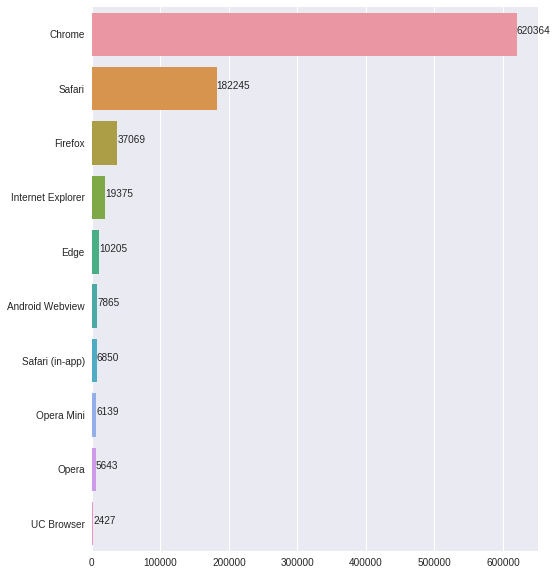

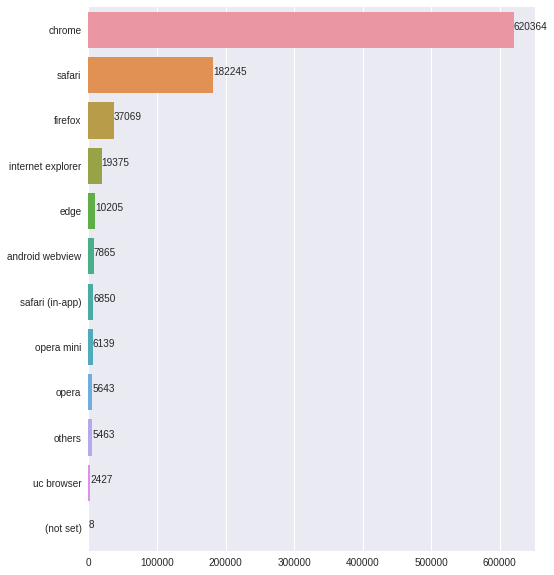

In [15]:
x=train_df1['device.browser'].value_counts()
print("Plot of top 10 device browsers before transformation")
wrang.plots(x[:10])
train_df1['device.browser'] = train_df1['device.browser'].map(lambda x:wrang.browser_wrangling(str(x).lower())).astype('str')
x=train_df1['device.browser'].value_counts()
print("Plot of device browsers after transformation")
wrang.plots(x)


Plot of top 10 Sources before transformation
Plot of Sources after transformation


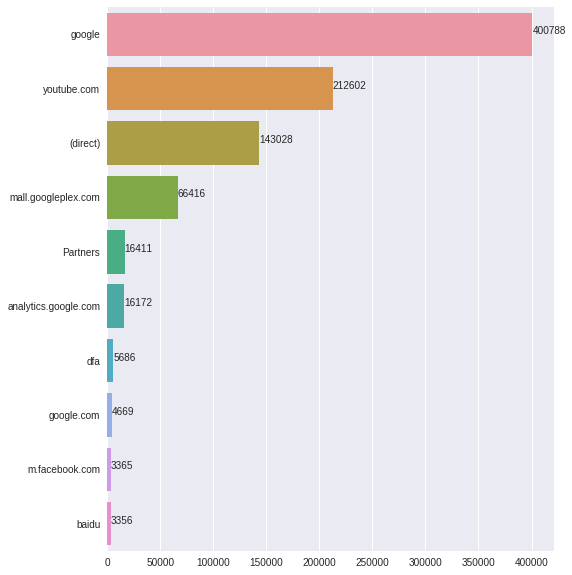

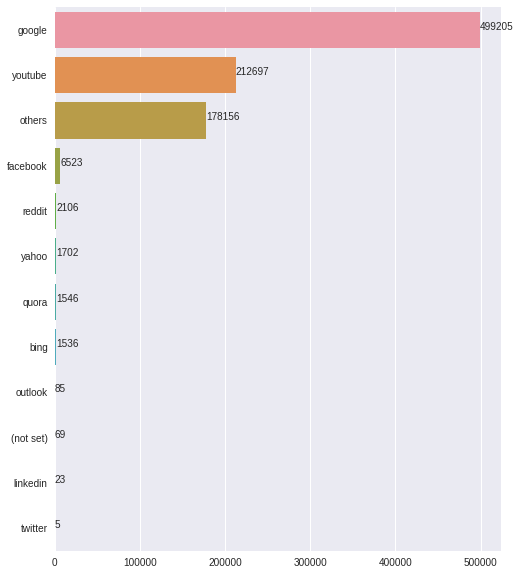

In [16]:
x=train_df1['trafficSource.source'].value_counts()
print("Plot of top 10 Sources before transformation")
wrang.plots(x[:10])
train_df1['trafficSource.source'] = train_df1['trafficSource.source'].map(lambda x:wrang.source_wrangling(str(x).lower())).astype('str')
x=train_df1['trafficSource.source'].value_counts()
print("Plot of Sources after transformation")
wrang.plots(x)


Plot of top 10 Operating Systems before transformation
Plot of Operating Systems after transformation


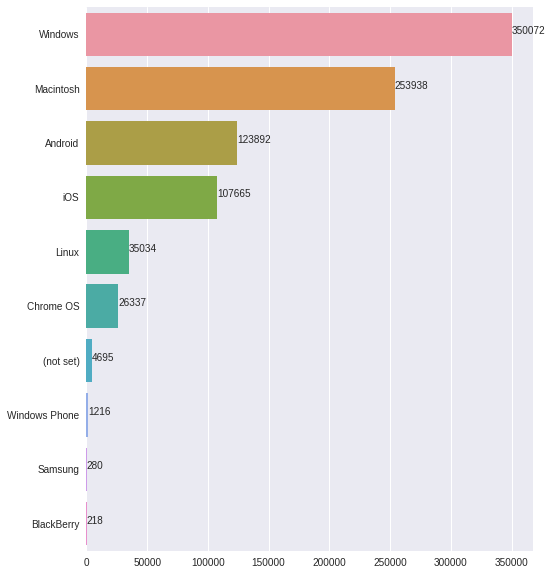

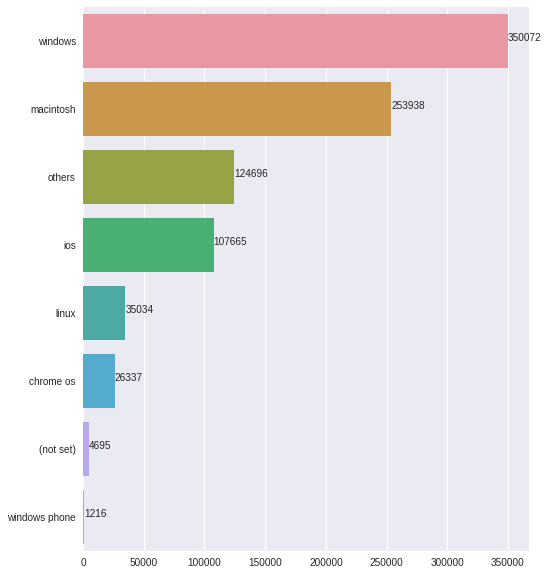

In [17]:
print("Plot of top 10 Operating Systems before transformation")
x=train_df1['device.operatingSystem'].value_counts()
wrang.plots(x[:10])
train_df1['device.operatingSystem'] = train_df1['device.operatingSystem'].map(lambda x:wrang.device_os_wrangling(str(x).lower())).astype('str')
x=train_df1['device.operatingSystem'].value_counts()
print("Plot of Operating Systems after transformation")
wrang.plots(x)

Plot of top 10 Network Domains before transformation
Plot of Network Domains after transformation


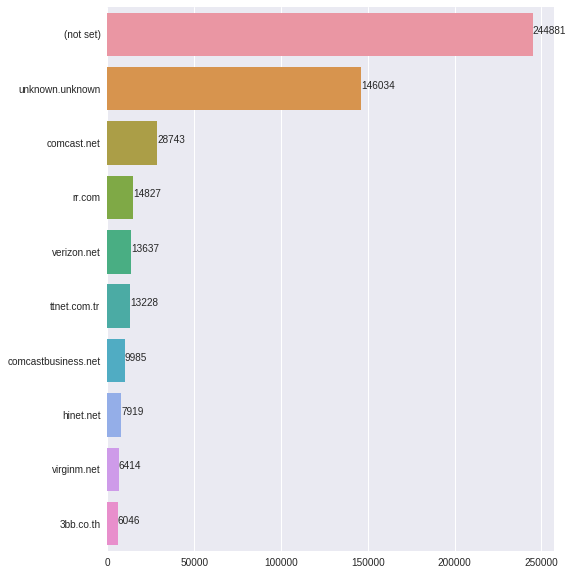

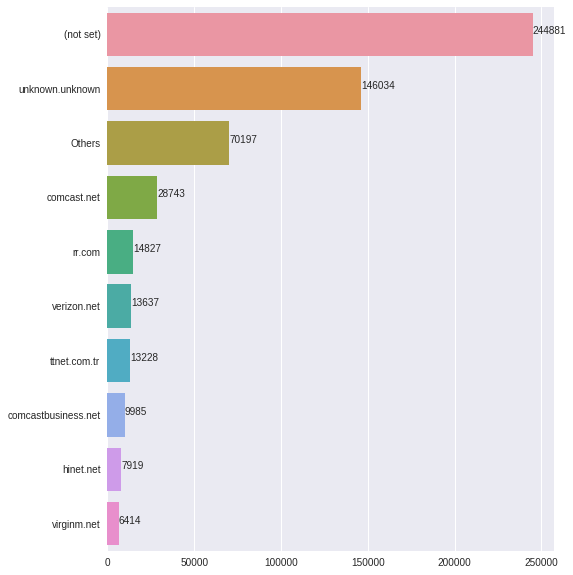

In [18]:
x=train_df1['geoNetwork.networkDomain'].value_counts()
print("Plot of top 10 Network Domains before transformation")
wrang.plots(x[:10])
train_df1 = wrang.nw_domain_wrangling(train_df1)
x=train_df1['geoNetwork.networkDomain'].value_counts()
print("Plot of Network Domains after transformation")
wrang.plots(x[:10])



### Creating New Features

In [19]:
'''
train_df1['date_of_visit'] = pd.to_datetime(train_df1['visitStartTime'], unit='s')
train_df1['day_of_the_week'] = train_df1['date_of_visit'].dt.dayofweek
train_df1['hour_of_the_day'] = train_df1['date_of_visit'].dt.hour
train_df1['day_of_the_month'] = train_df1['date_of_visit'].dt.day
'''

"\ntrain_df1['date_of_visit'] = pd.to_datetime(train_df1['visitStartTime'], unit='s')\ntrain_df1['day_of_the_week'] = train_df1['date_of_visit'].dt.dayofweek\ntrain_df1['hour_of_the_day'] = train_df1['date_of_visit'].dt.hour\ntrain_df1['day_of_the_month'] = train_df1['date_of_visit'].dt.day\n"

In [0]:
train_df1['source.country'] = train_df1['trafficSource.source'] + '_' + train_df1['geoNetwork.country']
train_df1['campaign.medium'] = train_df1['trafficSource.campaign'] + '_' + train_df1['trafficSource.medium']
train_df1['browser.category'] = train_df1['device.browser'] + '_' + train_df1['device.deviceCategory']
train_df1['browser.os'] = train_df1['device.browser'] + '_' + train_df1['device.operatingSystem']

In [0]:
train_df1['device_deviceCategory_channelGrouping'] = train_df1['device.deviceCategory'] + "_" + train_df1['channelGrouping']
train_df1['channelGrouping_browser'] = train_df1['device.browser'] + "_" + train_df1['channelGrouping']
train_df1['channelGrouping_OS'] = train_df1['device.operatingSystem'] + "_" + train_df1['channelGrouping']
train_df1['content.source'] = train_df1['trafficSource.adContent'] + "_" + train_df1['source.country']
train_df1['medium.source'] = train_df1['trafficSource.medium'] + "_" + train_df1['source.country']

### Removing unwanted columns/features

In [0]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

excluded_features = excluded_features + missing_cols

categorical_features = [
    _f for _f in train_df1.columns
    if (_f not in excluded_features) & (train_df1[_f].dtype == 'object')
]

### Factorizing the categorical features

In [0]:
for f in categorical_features:
    train_df1[f], indexer = pd.factorize(train_df1[f])
req_features = [_f for _f in train_df1.columns if _f not in excluded_features]
train_df2 = train_df1[req_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [24]:
train_df2['Revenue_Generating_Flag'].value_counts()

0.0    713689
1.0     10114
Name: Revenue_Generating_Flag, dtype: int64

*Note : We can see that only 1.4% of the customers are Revenue Generating Customers*

In [0]:
y = train_df2['Revenue_Generating_Flag']
X = train_df2.loc[:, train_df2.columns != 'Revenue_Generating_Flag']

del train_df2['Revenue_Generating_Flag']
train_df2 = train_df2.reset_index()

train, test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.3,random_state=20)

### Checking the distribution of the target variable in train and test

In [26]:
print(y_test.value_counts())
y_train.value_counts()

0.0    214107
1.0      3034
Name: Revenue_Generating_Flag, dtype: int64


0.0    499582
1.0      7080
Name: Revenue_Generating_Flag, dtype: int64

In [27]:
3034/(3034+214107)

0.013972487922594075

In [28]:
7080/(7080+499582)

0.013973812916697918

*We will proceed to perform SMOTE to accomodate the target variable imbalance on the training data*

### Performing SMOTE

In [0]:
train.fillna(train.median(),inplace=True)
sm = SMOTE(random_state=12, ratio = 0.2)
x_train_res, y_train_res = sm.fit_sample(train, y_train)
x_train_res = pd.DataFrame(x_train_res)
x_train_res.columns = train.columns
y_train_res = pd.DataFrame(y_train_res)
#y_train_res.columns = y_train.columns

In [30]:
print(train.shape)
print(y_train.shape)
print(x_train_res.shape)
print(y_train_res.shape)

(506662, 31)
(506662,)
(599498, 31)
(599498, 1)


In [31]:
print(y_train_res[0].value_counts())

0.0    499582
1.0     99916
Name: 0, dtype: int64


In [32]:
99916/(99916+499582)

0.16666611064590708

*Because of SMOTE we can see that the Revenue Generating customers are now incresed to ~17%*

### Spliting the Training Data into 5 Folds 

In [0]:
skf = StratifiedKFold(n_splits=5)

In [34]:
for a,b in skf.split(x_train_res,y_train_res):
    print(y_train_res[0].iloc[a].value_counts())
    print(y_train_res[0].iloc[b].value_counts())

0.0    399665
1.0     79932
Name: 0, dtype: int64
0.0    99917
1.0    19984
Name: 0, dtype: int64
0.0    399665
1.0     79933
Name: 0, dtype: int64
0.0    99917
1.0    19983
Name: 0, dtype: int64
0.0    399666
1.0     79933
Name: 0, dtype: int64
0.0    99916
1.0    19983
Name: 0, dtype: int64
0.0    399666
1.0     79933
Name: 0, dtype: int64
0.0    99916
1.0    19983
Name: 0, dtype: int64
0.0    399666
1.0     79933
Name: 0, dtype: int64
0.0    99916
1.0    19983
Name: 0, dtype: int64


In [35]:
79932/(79932+399665)

0.1666649290967208

In [36]:
19984/(19984+99917)

0.16667083677367162

*Since we gave stratified Kfold we ensure equal distribution of the target variable*

### Tuning Logistic Regression Hyperparameter

In [0]:
class tune:
    def logreg(self,x_train_res,y_train_res):
        lambda_vals = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
        #lambda_vals = [1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
        lambda_vals1 = np.reciprocal(lambda_vals)
        acc_table = pd.DataFrame(columns = ['lambda_vals','CV_AUC'])
        acc_table['lambda_vals'] = lambda_vals

        j=0
        for i in lambda_vals1:
            avg = 0
            for a,b in skf.split(x_train_res,y_train_res):
                trn_x, trn_y = x_train_res.iloc[a], y_train_res[0].iloc[a]
                val_x, val_y = x_train_res.iloc[b], y_train_res[0].iloc[b]
                lr = LogisticRegression(penalty = 'l2', C = i,random_state=20)
                lr.fit(trn_x,trn_y)
                test_pred = lr.predict_proba(val_x)[:,1]
                avg+=roc_auc_score(val_y, test_pred)

            avg1 = avg/5.0
            acc_table.iloc[j,1] = avg1
            j = j+1

        return acc_table
    def rftune(self,x_train_res,y_train_res):
        param_grid = { 
            'n_estimators': [300,400,500],
            'max_depth' : [6,7,8]
        }
        rfc = RandomForestClassifier(random_state=20)
        CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
        CV_rfc.fit(x_train_res, y_train_res)
        return CV_rfc.best_params_
      
   
    def gbmtune(self,x_train_res,y_train_res):
      
      parameters = {
      "learning_rate": [0.05, 0.1, 0.2],
     # "learning_rate": [0.2],
      #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #  "min_samples_leaf": [0.1,0.2,0.3,0.4,0.5], #np.linspace(0.1, 0.5, 12),
      "max_depth":[5,6,7,8],
      #"max_depth":[8],
      #"max_features":["log2","sqrt"],
      #"scoring": ["roc_auc"],
     #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
      "n_estimators":[200,300,400,500]
      #"n_estimators":[500]
      }

      cv_gbm = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3)
      cv_gbm.fit(x_train_res,y_train_res)
      return cv_gbm.best_params_

In [0]:
tuner=tune()
#acc_table=tuner.logreg(x_train_res,y_train_res)
#best_params = tuner.rftune(x_train_res,y_train_res)
#print(acc_table)
#print(best_params)
best_params_gbm = tuner.gbmtune(x_train_res,y_train_res)

In [39]:
acc_table

,lambda_vals,CV_AUC
0,1.000000e-03,0.978879
1,1.000000e-02,0.978871
2,1.000000e-01,0.97886
3,1.000000e+00,0.978881
4,1.000000e+01,0.978896
5,1.000000e+02,0.978942
6,1.000000e+03,0.978266
7,1.000000e+04,0.971264
8,1.000000e+05,0.952654
9,1.000000e+06,0.927699


In [42]:
1/1.000000e+02

0.01

In [0]:
lambda_vals = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
#lambda_vals = [1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
lambda_vals1 = np.reciprocal(lambda_vals)
acc_table = pd.DataFrame(columns = ['lambda_vals','CV_AUC'])
acc_table['lambda_vals'] = lambda_vals

j=0
for i in lambda_vals1:
    avg = 0
    for a,b in skf.split(x_train_res,y_train_res):
        trn_x, trn_y = x_train_res.iloc[a], y_train_res[0].iloc[a]
        val_x, val_y = x_train_res.iloc[b], y_train_res[0].iloc[b]
        lr = LogisticRegression(penalty = 'l2', C = i,random_state=20)
        lr.fit(trn_x,trn_y)
        test_pred = lr.predict_proba(val_x)[:,1]
        avg+=roc_auc_score(val_y, test_pred)

    avg1 = avg/5.0
    acc_table.iloc[j,1] = avg1
    j = j+1

acc_table

### Building Logistic Regression Model on the obtained Hyperparameter

#### Keeping aside 20% of the train data as validation which can be used for ensemble and stacking later

In [0]:
#x_train_res = train
#y_train_res = y_train

x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

val_table = pd.DataFrame(columns = ['Actuals','glm','rf','gbm'])
val_table['Actuals'] = y1_test[0]
test_table = pd.DataFrame(columns = ['Actuals','glm','rf','gbm'])
test_table['Actuals'] = y_test

#train_features = [_f for _f in x_train_res.columns if _f not in excluded_features]
x1_train.fillna(x1_train.median(),inplace=True)
x1_test.fillna(x1_test.median(),inplace=True)
test.fillna(test.median(),inplace=True)

lr = LogisticRegression(penalty = 'l2', C = 0.01,random_state=20)
lr.fit(x1_train,y1_train)

val_table['glm'] = lr.predict_proba(x1_test)[:,1]
test_table['glm'] = lr.predict_proba(test)[:,1]


##### Checking the distribution of the probabilities across the Validation sets

In [65]:
val_table['glm'].describe()

count    1.199000e+05
mean     1.672583e-01
std      3.022101e-01
min      1.853847e-08
25%      8.681301e-04
50%      1.166639e-02
75%      1.258027e-01
max      1.000000e+00
Name: glm, dtype: float64

#### Getting the AUC value for the validation for the tuned Logistic Regression Model

In [67]:
print(roc_auc_score(val_table['Actuals'], val_table['glm']))
avg1 = np.where(val_table['glm']<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9788977849162721


col_0,0,1
Actuals,,
0.0,96226,3691
1.0,2636,17347


In [68]:
print(roc_auc_score(val_table['Actuals'], val_table['glm']))
avg1 = np.where(val_table['glm']<0.5,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9788977849162721


col_0,0,1
Actuals,,
0.0,97049,2868
1.0,3984,15999


In [69]:
print(roc_auc_score(val_table['Actuals'], val_table['glm']))
avg1 = np.where(val_table['glm']<0.6,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9788977849162721


col_0,0,1
Actuals,,
0.0,97671,2246
1.0,5749,14234


#### Predicting on the hold-out Test Data using the Tuned Model

In [98]:
print(roc_auc_score(test_table['Actuals'], test_table['glm']))
avg1 = np.where(test_table['glm']<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9754227835287317


col_0,0,1
Actuals,,
0.0,206105,8002
1.0,487,2547


In [99]:
2547/(2547+487)

0.8394858272907053

### We would be more interested in the recall value of the predictions because in this case no. of revenue generating customers will be very low compared to the non revenue generating customers cases and sometime a revenue generating customer will be predicted as non profitable. So, recall will give us a sense of only profitable customers.

In [0]:
2346/(2346+688)

#### We observe a ~77% recall score on the test set for the tuned Logistic Regression

### Tuning Random Forest Parameters

In [0]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

x1_train.fillna(x1_train.median(),inplace=True)
x1_test.fillna(x1_test.median(),inplace=True)
test.fillna(test.median(),inplace=True)

clf_rf = RandomForestClassifier(n_estimators=400,max_depth=8,random_state=20)
clf_rf.fit(x1_train, y1_train)

val_table['rf'] = clf_rf.predict_proba(x1_test)[:,1]
test_table['rf'] = clf_rf.predict_proba(test)[:,1]

In [71]:
print(roc_auc_score(val_table['Actuals'], val_table['rf']))
avg1 = np.where(val_table['rf']<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9932529091474404


col_0,0,1
Actuals,,
0.0,96689,3228
1.0,553,19430


In [72]:
print(roc_auc_score(val_table['Actuals'], val_table['rf']))
avg1 = np.where(val_table['rf']<0.5,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9932529091474404


col_0,0,1
Actuals,,
0.0,97365,2552
1.0,984,18999


In [73]:
print(roc_auc_score(val_table['Actuals'], val_table['rf']))
avg1 = np.where(val_table['rf']<0.6,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9932529091474404


col_0,0,1
Actuals,,
0.0,98060,1857
1.0,1915,18068


In [96]:
print(roc_auc_score(test_table['Actuals'],test_table['rf']))
avg1 = np.where(test_table['rf']<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9856292713493301


col_0,0,1
Actuals,,
0.0,207153,6954
1.0,348,2686


In [109]:
test_table['rf'].describe()

count    217141.000000
mean          0.047326
std           0.148384
min           0.000009
25%           0.000206
50%           0.001304
75%           0.011344
max           0.941873
Name: rf, dtype: float64

In [97]:
2686/(2686+348)

0.8852999340804218

In [108]:
2686/(2686+6954)

0.2786307053941909

###  Gradient Boosting

In [0]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

In [0]:
x1_train.fillna(x1_train.median(),inplace=True)
x1_test.fillna(x1_test.median(),inplace=True)
test.fillna(test.median(),inplace=True)

#cf_gb = GradientBoostingClassifier(learning_rate=0.03,max_depth=8,n_estimators=500,random_state=20)
cf_gb = GradientBoostingClassifier(n_estimators=700,random_state=20)
cf_gb.fit(x1_train, y1_train)

#val_gbm = cf_gb.predict_proba(x1_test)[:,1]
#test_gbm = cf_gb.predict_proba(test)[:,1]

val_table['gbm'] = cf_gb.predict_proba(x1_test)[:,1]
test_table['gbm'] = cf_gb.predict_proba(test)[:,1]

In [80]:
print(roc_auc_score(val_table['Actuals'], val_gbm))
avg1 = np.where(val_gbm<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9956987281478357


col_0,0,1
Actuals,,
0.0,97472,2445
1.0,762,19221


In [81]:
print(roc_auc_score(val_table['Actuals'], val_gbm))
avg1 = np.where(val_gbm<0.5,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9956987281478357


col_0,0,1
Actuals,,
0.0,97919,1998
1.0,1169,18814


In [82]:
print(roc_auc_score(val_table['Actuals'], val_gbm))
avg1 = np.where(val_gbm<0.6,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9956987281478357


col_0,0,1
Actuals,,
0.0,98319,1598
1.0,1633,18350


In [104]:
print(roc_auc_score(test_table['Actuals'], test_gbm))
avg1 = np.where(test_gbm<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9862067130543675


col_0,0,1
Actuals,,
0.0,208715,5392
1.0,504,2530


In [105]:
2530/(2530+504)

0.8338826631509558

In [106]:
2530/(2530+5392)

0.3193637970209543